# GrowthViz - Adults

## Background - growthcleanr

[growthcleanr](https://github.com/carriedaymont/growthcleanr) is an automated method for identifying implausible values in anthropometric data from EHRs. It is available as open source software. It was originally designed with a focus on pediatric growth data, as stated in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271):

> In pediatrics, evaluation of growth is fundamental, and many pediatric research studies include some aspect of growth as an outcome or other variable. The clinical growth measurements obtained in day-to-day care are susceptible to error beyond the imprecision inherent in any anthropometric measurement. Some errors result from minor problems with measurement technique. While these errors can be important in certain analyses, they are often small and generally impossible to detect after measurements are recorded. Larger measurement technique errors can result in values that are biologically implausible and can cause problems for many analyses. 

The `growthcleanr` package has been expanded to identify implausible height and weight observations among adult subjects, from 18 up to age 65. This notebook supports review of `growthcleanr` results when working with data from **adult** subjects. If you are primarily working with pediatric subjects, please use the `GrowthViz-pediatrics.ipynb` notebook instead.

## GrowthViz Purpose

The objective of this tool is to allow users to conduct post-processing and data visualization of growthcleanr output. GrowthViz is to be used **after** a data set has been run through growthcleanr.

GrowthViz is a [Juypter Notebook](https://jupyter.org/). It provides an environment that includes graphical user interfaces as well as interactive software development to explore data. To achieve this, GrowthViz references different software languages and packages:
 - [Python programming language](https://www.python.org/) is used to import, transform, visualize and analyze the output of growthcleanr. Some of the code for the tool is directly included in this notebook. Other functions have been placed in external files to minimize the amount of code that users see in order to let them focus on the actual data.
 - Data analysis is performed using [NumPy](https://numpy.org/) and [Pandas](https://pandas.pydata.org/). The output of growthcleanr will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). GrowthViz provides functions for transforming DataFrames to support calculation of some values, such as BMI, as well as supporting visualizations. It is expected that users will create views into or copies of the DataFrames built initially by this tool. Adding columns to the DataFrames created by this tool is unlikely to cause problems. Removing columns is likely to break some of the tool's functionality.
 - Visualization in the tool is provided by [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/). Users may generate their own charts with these utilities.

---
# Setting Up the Environment

Jupyter Notebooks have documentation cells, such as this one, and code cells like the one below. The notebook server runs the code and provides results (if applicable) back in the notebook. The following code cell loads the libraries necessary for the tool to work. If you would like to incorporate other Python libraries to assist in data exploration, they can be added here. Removing libraries from this cell will very likely break the tool.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import FileLink, FileLinks
import qgrid

The next two code cells tell the notebook server to automatically reload the externally defined Python functions created to assist in data analysis.

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

This code cell instructs the notebook to automatically display plots inline.

In [4]:
%matplotlib inline

This code cell tells the notebook to output plots for high DPI displays, such as 4K monitors, many smartphones or a retina display on Apple hardware. This cell does not need to be run and can be safely removed. If removed, charts will look more "blocky" or "pixelated" on high DPI displays.

In [5]:
%config InlineBackend.figure_format = 'retina'

# Loading Data

The following cell imports functions created for the tool to assist in data analysis. Some of the functions generate charts used in this tool. The chart code may be modified to change the appearance of plots without too much risk of breaking things. Other functions transform DataFrames and changing those will very likely cause things to break. If you are unable to tell the difference in the functions by looking at the code, it is probably best to leave them unmodified.

In [6]:
from growthviz import charts
from growthviz import check_data
from growthviz import compare
from growthviz import processdata
from growthviz import sumstats

This cell reads in a data set that has been run through the [growthcleanr](https://github.com/carriedaymont/growthcleanr) algorithm. Details of the algorithm can be found in [Automated identification of implausible values in growth data from pediatric electronic health records](https://academic.oup.com/jamia/article/24/6/1080/3767271)

<a id="input_structure"></a>
Data is expected to be in a CSV file with the following structure:

| Column | Description |
|--------|-------------|
| id | A unique identifier for an observation |
| subjid | An identifier for the individual from which the observation was obtained |
| sex | A numeric value of 0 (male) or 1 (female). Note that this differs from the CDC Growth Chart Data Tables. |
| agedays | Number representing the age of the patient in days when the observation was obtained |
| param | The type of observation along with units. Expected values are *HEIGHTCM* and *WEIGHTKG* |
| measurement | A decimal number that represents the observation value. |
| clean_res | The categorization of the observation by growthcleanr. |

This information will be loaded into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called `cleaned_obs`

In [7]:
cleaned_obs = pd.read_csv("growthviz-data/sample-adults-data.csv")

The following cell shows what the first five rows look like in the CSV file

In [8]:
cleaned_obs.head()

,id,subjid,sex,agedays,param,measurement,clean_res
0,31,1001,1,6629,HEIGHTCM,171.4,Include
1,32,1001,1,6629,WEIGHTKG,48.6,Include
2,33,1001,1,6629,WEIGHTKG,48.9,Exclude-Adult-Extraneous-Same-Day
3,34,1001,1,6629,HEIGHTCM,171.8,Exclude-Adult-Extraneous-Same-Day
4,35,1001,1,7000,HEIGHTCM,171.5,Include


This next cell runs through a series of data checks on the original data file, such as making sure all values of `sex` are either 0 or 1, or no age values are negative.

In [9]:
warnings = check_data.check_patient_data("growthviz-data/sample-adults-data.csv")
if warnings:
    for warning in warnings:
        print(warning)
else:
    print("Data looks good!")

Data looks good!


Next, the `processdata.setup_individual_obs_df` function performs transformations on the `cleaned_obs` DataFrame. This will create an `age` column, which is a decimal column that represents the patient's age in years at the time of the observation. It changes the `clean_value` column into a [pandas categorical type](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html). It also create an `include` column which contains a boolean value indicating whether growthcleanr states to include (true) or exclude (false) the observation. The resulting DataFrame is assigned to `obs_full`.

In [10]:
obs_full = processdata.setup_individual_obs_df(cleaned_obs)

In [11]:
obs_full.head()

,id,subjid,param,measurement,age,sex,clean_value,clean_cat,include
0,31,1001,HEIGHTCM,171.4,18.149213,1,Include,Include,True
1,32,1001,WEIGHTKG,48.6,18.149213,1,Include,Include,True
2,33,1001,WEIGHTKG,48.9,18.149213,1,Exclude-Adult-Extraneous-Same-Day,Exclude-Adult-Extraneous-Same-Day,False
3,34,1001,HEIGHTCM,171.8,18.149213,1,Exclude-Adult-Extraneous-Same-Day,Exclude-Adult-Extraneous-Same-Day,False
4,35,1001,HEIGHTCM,171.5,19.164956,1,Include,Include,True


In the following cell, the `charts.make_age_charts` function visually displays the range of ages in the dataset, with those to be excluded identified by the red bars with the **x** pattern, and those that are outside the optimal range of the notebook identified by the orange bars with the **/** pattern. As noted above, if the population in the dataset is primarily pediatrics, you will want to switch to the pediatrics notebook.

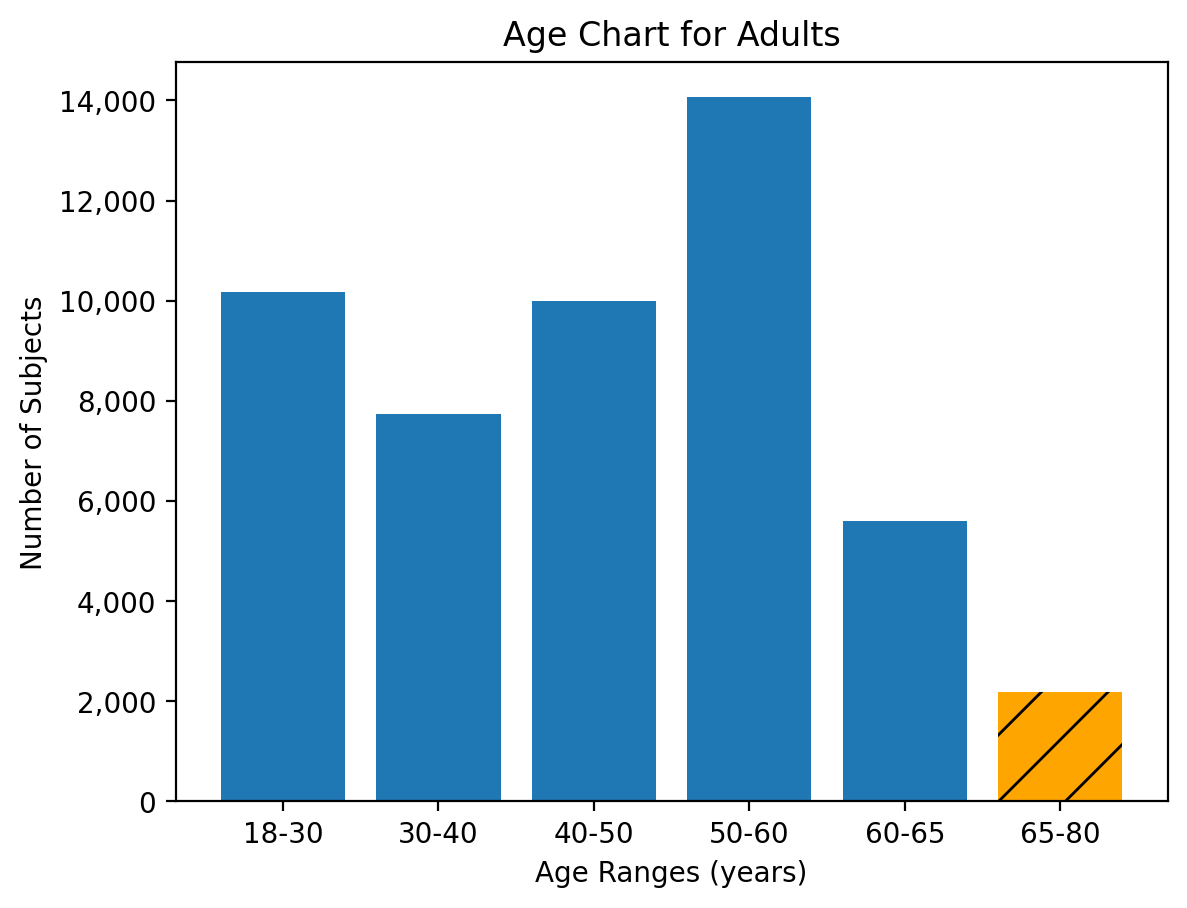

In [12]:
charts.make_age_charts(obs_full, 'adults')

The chart above shows adult age ranges supported by the rest of this notebook, any observations that fall outside of those ranges.

Now, we will filter the age ranges to match the supported adult ranges.

In [13]:
obs = processdata.keep_age_range(obs_full, 'adults')

After that, `charts.weight_distr` creates two visualizations. The first shows a distribution of all of the included weights in the dataset. The second shows weights above a certain threshold to see whether there are spikes at a certain *Included* weights that might indicate that a commonly used scale maxes out at a certain value. This chart is restricted to values of 135kg or higher (rounded to the nearest KG) to make patterns in higher weights easier to identify. This potential issue is important to keep in mind when conducting an analysis.

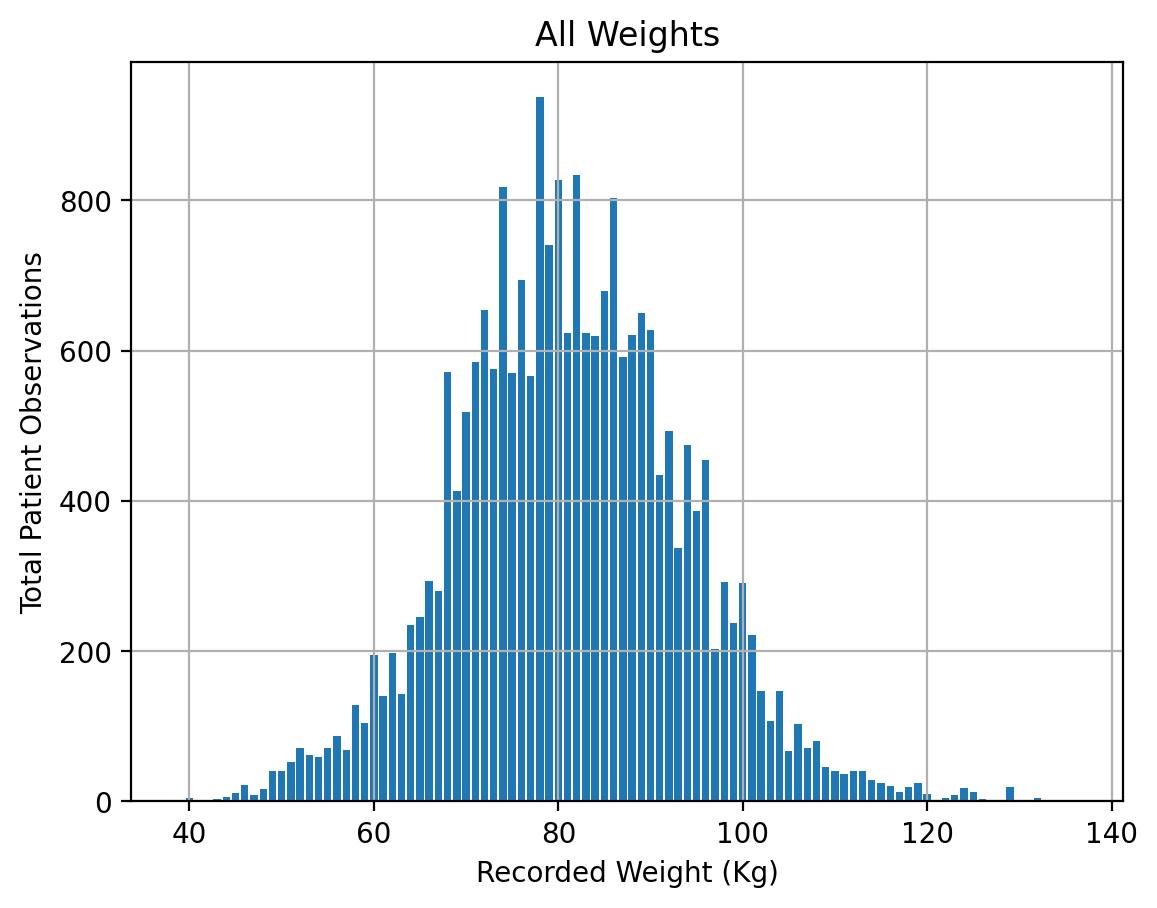

In [14]:
charts.weight_distr(obs, 'all')

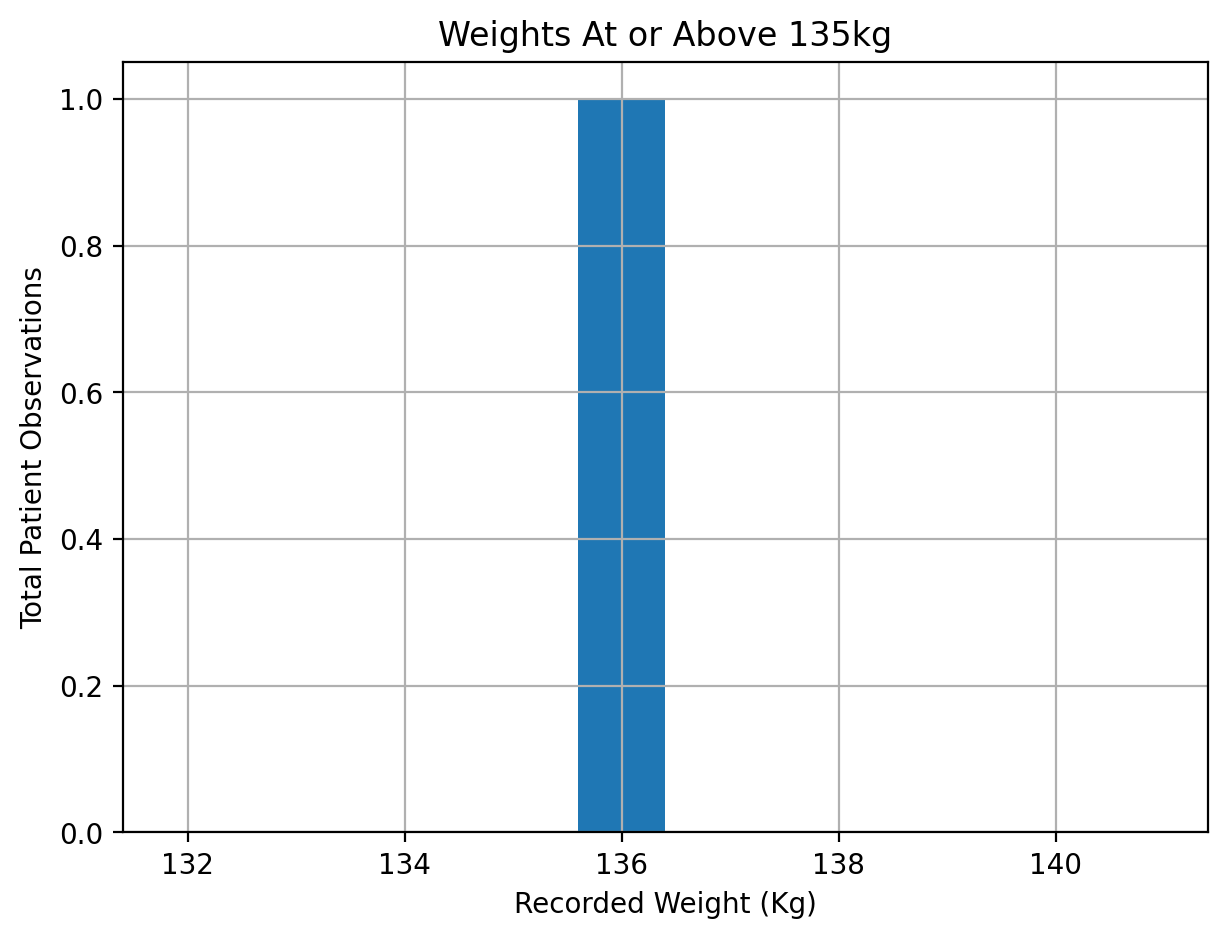

In [15]:
charts.weight_distr(obs, 'high')

The following cell loads in the [CDC Anthropometric Reference Data for Adults](https://www.cdc.gov/nchs/data/series/sr_03/sr03-046-508.pdf). Rows, which represent decades (e.g., 20-29), are expanded so that there is one record per year. Standard deviation is calculated from the count of examined persons and the standard error. `Sex` is then transformed so that the values align with the values used in growthcleanr, 0 (male) or 1 (female). Finally, percentiles are smoothed across decade changes (e.g., any change happens gradually from 29 to 31). This data is used to plot percentile bands in visualizations in the tool. 

In [16]:
# adult percentiles
percentiles = pd.read_csv("growthviz-data/ext/vdsmeasures.csv", encoding ='latin1')
percentiles_clean = processdata.setup_percentiles_adults(percentiles)

# save out smoothed percentiles
percentiles_clean.drop(columns={'sd'}).to_csv('smoothed_percentiles.csv')

# separate percentiles into different data files
bmi_percentiles = percentiles_clean[percentiles_clean['param'] == 'BMI']
wt_percentiles = percentiles_clean[percentiles_clean['param'] == 'WEIGHTKG']
ht_percentiles = percentiles_clean[percentiles_clean['param'] == 'HEIGHTCM']

percentiles_clean.head(15)

,param,Sex,age,Mean,sd,P5,P10,P15,P25,P50,P75,P85,P90,P95
0,WEIGHTKG,1,18,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
1,WEIGHTKG,1,19,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
2,WEIGHTKG,1,20,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
3,WEIGHTKG,1,21,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
4,WEIGHTKG,1,22,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
5,WEIGHTKG,1,23,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
6,WEIGHTKG,1,24,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
7,WEIGHTKG,1,25,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
8,WEIGHTKG,1,26,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4
9,WEIGHTKG,1,27,74.9,32.496097,48.5,51.4,53.8,58.4,69.5,86.4,98.4,107.0,118.4


In this cell, the percentiles data are reshaped to provide mean and standard deviation values for each parameter that will later be used for z-score calculations.

In [17]:
percentiles_wide = sumstats.setup_percentile_zscore_adults(percentiles_clean)
percentiles_wide.head()

,sex,age,Mean_bmi,sd_bmi,Mean_height,sd_height,Mean_weight,sd_weight,rounded_age
0,0,18,27.6,12.169836,175.8,8.495881,85.5,40.780231,18
1,0,19,27.6,12.169836,175.8,8.495881,85.5,40.780231,19
2,0,20,27.6,12.169836,175.8,8.495881,85.5,40.780231,20
3,0,21,27.6,12.169836,175.8,8.495881,85.5,40.780231,21
4,0,22,27.6,12.169836,175.8,8.495881,85.5,40.780231,22


In an earlier cell, the tool creates the `obs` DataFrame. In that structure there is one measurement, either height or weight, per row. In this cell, the `processdata.setup_merged_df` function will create a DataFrame where a height observation and weight observation for the same `subjid` on the same `agedays` are combined into a single row. Several new columns are added to the resulting DataFrame:

| Column | Description |
|--------|-------------|
| weight | The `measurement` value for observations that had the `param` of *WEIGHTKG* |
| height | The `measurement` value for observations that had the `param` of *HEIGHTCM* |
| bmi | The BMI calculated from `weight` and `height` |
| weight_cat | The value previously stored in `clean_value` for the weight observation |
| include_weight | The value previously stored in `include` for the weight observation |
| height_cat | The value previously stored in `clean_value` for the height observation |
| include_height | The value previously stored in `include` for the height observation |
| include_both | Logical AND of `include_weight` and `include_height` |

The result is stored in `merged_df`.

In [18]:
merged_df = processdata.setup_merged_df(obs)
merged_df.head()

,id,subjid,age,sex,height_cat,include_height,category_x,colors_x,patterns_x,sort_order_x,...,weight_cat,include_weight,category_y,colors_y,patterns_y,sort_order_y,weight,bmi,rounded_age,include_both
0,31.0,1001,18.149213,1,Include,True,18-30,C0,,B,...,Include,True,18-30,C0,,B,48.6,16.543014,18.0,True
1,31.0,1001,18.149213,1,Include,True,18-30,C0,,B,...,Exclude-Adult-Extraneous-Same-Day,False,18-30,C0,,B,48.9,16.645131,18.0,False
2,34.0,1001,18.149213,1,Exclude-Adult-Extraneous-Same-Day,False,18-30,C0,,B,...,Include,True,18-30,C0,,B,48.6,16.466070,18.0,False
3,34.0,1001,18.149213,1,Exclude-Adult-Extraneous-Same-Day,False,18-30,C0,,B,...,Exclude-Adult-Extraneous-Same-Day,False,18-30,C0,,B,48.9,16.567712,18.0,False
4,35.0,1001,19.164956,1,Include,True,18-30,C0,,B,...,Include,True,18-30,C0,,B,48.8,16.591726,19.0,True


In the following cell, `processdata.setup_bmi_adults` calculates BMI for each weight and height pairing to be used in later individual trajectory visualizations.

In [19]:
obs_wbmi = processdata.setup_bmi_adults(merged_df, obs)  

## Exclusion Information

The following shows the counts of the values for inclusion/exclusion along with the percentages of total. 

In [20]:
processdata.exclusion_information(obs)

param,HEIGHTCM,height percent,WEIGHTKG,weight percent,total
clean_cat,,,,,
Include,16751,78.25%,22693,80.00%,39444
Exclude-Adult-Extraneous-Same-Day,3812,17.81%,4656,16.41%,8468
Exclude-Adult-Identical-Same-Day,402,1.88%,871,3.07%,1273
Exclude-Adult-Distinct-3-Or-More,220,1.03%,0,0.00%,220
Exclude-Adult-BIV,161,0.75%,55,0.19%,216
Exclude-Adult-EWMA-Moderate,0,0.00%,33,0.12%,33
Exclude-Adult-EWMA-Extreme,0,0.00%,30,0.11%,30
Exclude-Adult-Swapped-Measurements,12,0.06%,12,0.04%,24
Exclude-Adult-Distinct-Pairs,18,0.08%,0,0.00%,18


# Finding Individuals

This next cell creates an interactive tool that can be used to explore patients. The `sumstats.add_mzscored_to_merged_df` function will add modified Z Scores for height, weight and BMI to `merged_df`. The tool uses [Qgrid](https://github.com/quantopian/qgrid) to create the interactive table. Clicking on a row will create a plot for the individual below the table.

In [49]:
lastSubj = "0000"
currSubj = "0000"
mdf = sumstats.add_mzscored_to_merged_df_adults(merged_df, percentiles_wide) 
mdf['wtz'] = (mdf['weight'] - mdf['Mean_weight'])/mdf['sd_weight']
mdf['htz'] = (mdf['height'] - mdf['Mean_height'])/mdf['sd_height']
mdf['BMIz'] = (mdf['bmi'] - mdf['Mean_bmi'])/mdf['sd_bmi']
mdf.head()

col_opt = {
    'width': 20,
}
col_def = {
    'subjid': { 'width': 80 },
    'sex': { 'width': 30 },
    'age': { 'width': 30 },
    'height': { 'width': 50 },
    'height_cat': { 'width': 80 },
    'htz': { 'width': 50 },
    'weight': { 'width': 50 },
    'weight_cat': { 'width': 80 },
    'wtz': { 'width': 50 },
    'bmi': { 'width': 40 },
    'BMIz': { 'width': 30 },
}
g = qgrid.show_grid(charts.top_ten(mdf, 'weight'), precision=3, column_options=col_opt, column_definitions=col_def)
ind_out = widgets.Output()
def handle_selection_change(_event, _widget):
    global lastSubj, currSubj
    sdf = g.get_selected_df()
    if sdf.shape[0] >= 1:
        subjid = sdf.subjid.iloc[0]
        currSubj = subjid
        with ind_out:
            if currSubj != lastSubj:
                ind_out.clear_output()
                charts.overlap_view_adults(obs, subjid, 'WEIGHTKG', True, True, wt_percentiles, bmi_percentiles, ht_percentiles)
                display(plt.show())
        lastSubj = currSubj
g.on('selection_changed', handle_selection_change)    
widgets.VBox([g, ind_out])


It can be useful to copy values from the `subjid` column in the results above for use in visualizations in the rest of the tool.

---

# Visualizing an Individual Trajectory

The cell below creates a plot for an individual. It shows either the weight trajectory or height tragectory depending on the `param` value that is selected. The black bands in the diagram represent the 5th and 95th percentile values for age and sex for the given measurement type. For BMI tables, the bands used can be found in the [CDC Definitions of Obesity](https://www.cdc.gov/obesity/adult/defining.html). 

In this chart, the blue line represents all measurements for an individual. Any values marked for exclusion are represented with a red x. The yellow dashed line represents the trajectory with exclusions removed. Any carried forward values are represented by a blue triangle, unless `include_carry_forward` is set to False, when they will also be represented as a red x.

In [22]:
all_ids = obs['subjid'].unique()
val = 2868 if 2868 in all_ids else np.random.choice(all_ids, size=1, replace=False)
interactive(charts.overlap_view_adults_show, obs_df=fixed(obs_wbmi), 
            subjid=widgets.Dropdown(options=all_ids, value=val, description='Subject ID:', disabled=False), 
            param=['HEIGHTCM', 'WEIGHTKG', 'BMI'], 
            include_carry_forward=widgets.Checkbox(value=True,description='Include Carry Forward',disabled=False,indent=False), 
            include_percentiles=widgets.Checkbox(value=True,description='Include Measurement Percentile Bands',disabled=False,indent=False),
            wt_df=fixed(wt_percentiles), bmi_df=fixed(bmi_percentiles), ht_df=fixed(ht_percentiles))

interactive(children=(Dropdown(description='Subject ID:', index=1867, options=(1001, 1002, 1003, 1004, 1005, 1…

In [23]:
obs_wbmi[obs_wbmi['subjid'] == 2868]

,id,subjid,param,measurement,age,sex,clean_value,clean_cat,include,category,colors,patterns,sort_order,rounded_age,weight_cat,height_cat,include_both
45164,70788.0,2868,HEIGHTCM,164.6,50.020534,1,Include,Include,True,50-60,C0,,E,NaN,NaN,NaN,NaN
45165,70789.0,2868,WEIGHTKG,82.2,50.020534,1,Include,Include,True,50-60,C0,,E,NaN,NaN,NaN,NaN
45166,70790.0,2868,WEIGHTKG,82.1,50.020534,1,Exclude-Adult-Extraneous-Same-Day,Exclude-Adult-Extraneous-Same-Day,False,50-60,C0,,E,NaN,NaN,NaN,NaN
45167,70791.0,2868,HEIGHTCM,164.6,50.940452,1,Include,Include,True,50-60,C0,,E,NaN,NaN,NaN,NaN
45168,70792.0,2868,WEIGHTKG,82.2,50.940452,1,Include,Include,True,50-60,C0,,E,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33171,NaN,2868,BMI,NaN,58.220397,1,Only Wt or Ht,Only Wt or Ht,NaN,NaN,NaN,NaN,NaN,58.0,Include,NaN,False
33172,NaN,2868,BMI,NaN,58.223135,1,Only Wt or Ht,Only Wt or Ht,NaN,NaN,NaN,NaN,NaN,58.0,Include,NaN,False
33173,NaN,2868,BMI,NaN,58.225873,1,Only Wt or Ht,Only Wt or Ht,NaN,NaN,NaN,NaN,NaN,58.0,Include,NaN,False
33174,NaN,2868,BMI,NaN,58.228611,1,Only Wt or Ht,Only Wt or Ht,NaN,NaN,NaN,NaN,NaN,58.0,Include,NaN,False


In [24]:
@interact(subjid=widgets.Dropdown(options=all_ids, value=val, description='Subject ID:', disabled=False))
def all_charts(subjid=val):
    charts.overlap_view_adults(obs_df=obs_wbmi, subjid=subjid, param='WEIGHTKG', include_carry_forward=True, 
            include_percentiles=True, wt_df=wt_percentiles, bmi_df=bmi_percentiles, ht_df=ht_percentiles)

    charts.overlap_view_adults(obs_df=obs_wbmi, subjid=subjid, param='BMI', include_carry_forward=True, 
            include_percentiles=True, wt_df=wt_percentiles, bmi_df=bmi_percentiles, ht_df=ht_percentiles)

    charts.overlap_view_adults(obs_df=obs_wbmi, subjid=subjid, param='HEIGHTCM', include_carry_forward=True, 
            include_percentiles=True, wt_df=wt_percentiles, bmi_df=bmi_percentiles, ht_df=ht_percentiles)
    plt.show()

interactive(children=(Dropdown(description='Subject ID:', index=1867, options=(1001, 1002, 1003, 1004, 1005, 1…

# Visualizing Multiple Trajectories at Once

Next, the tool creates a series that contains the unique set of `subjid`s that have more than one record per category (as determined by `charts.mult_obs`) and stores that in `uniq_ids`.

In [25]:
obs_wbmi_mult = charts.mult_obs(obs_wbmi)
uniq_ids = obs_wbmi_mult['subjid'].unique()

From the series of unique subjids, the following cell randomly selects 25 individuals and assigns them to `sample`. A random seed, which specifies the start point when a computer generates a random number sequence, is then set so that the random sample is reproducible. The random seed can be changed to change the sample generated.

In [26]:
np.random.seed(1)
sample = np.random.choice(uniq_ids, size=25, replace=False)

In [27]:
sample

array([1868, 2488, 1949, 2039, 1677, 2737, 1377, 1625, 1722, 1837, 2313,
       1357, 2381, 2576, 2676, 1732, 2748, 1382, 1114, 2535, 2224, 2361,
       2918, 1111, 1815], dtype=int64)

The `sample` can be passed into the `charts.five_by_five_view` function which will create a [small multiple](https://en.wikipedia.org/wiki/Small_multiple) plot for each of the individuals. Exclusions, including carry forwards, will be represented by a red x.

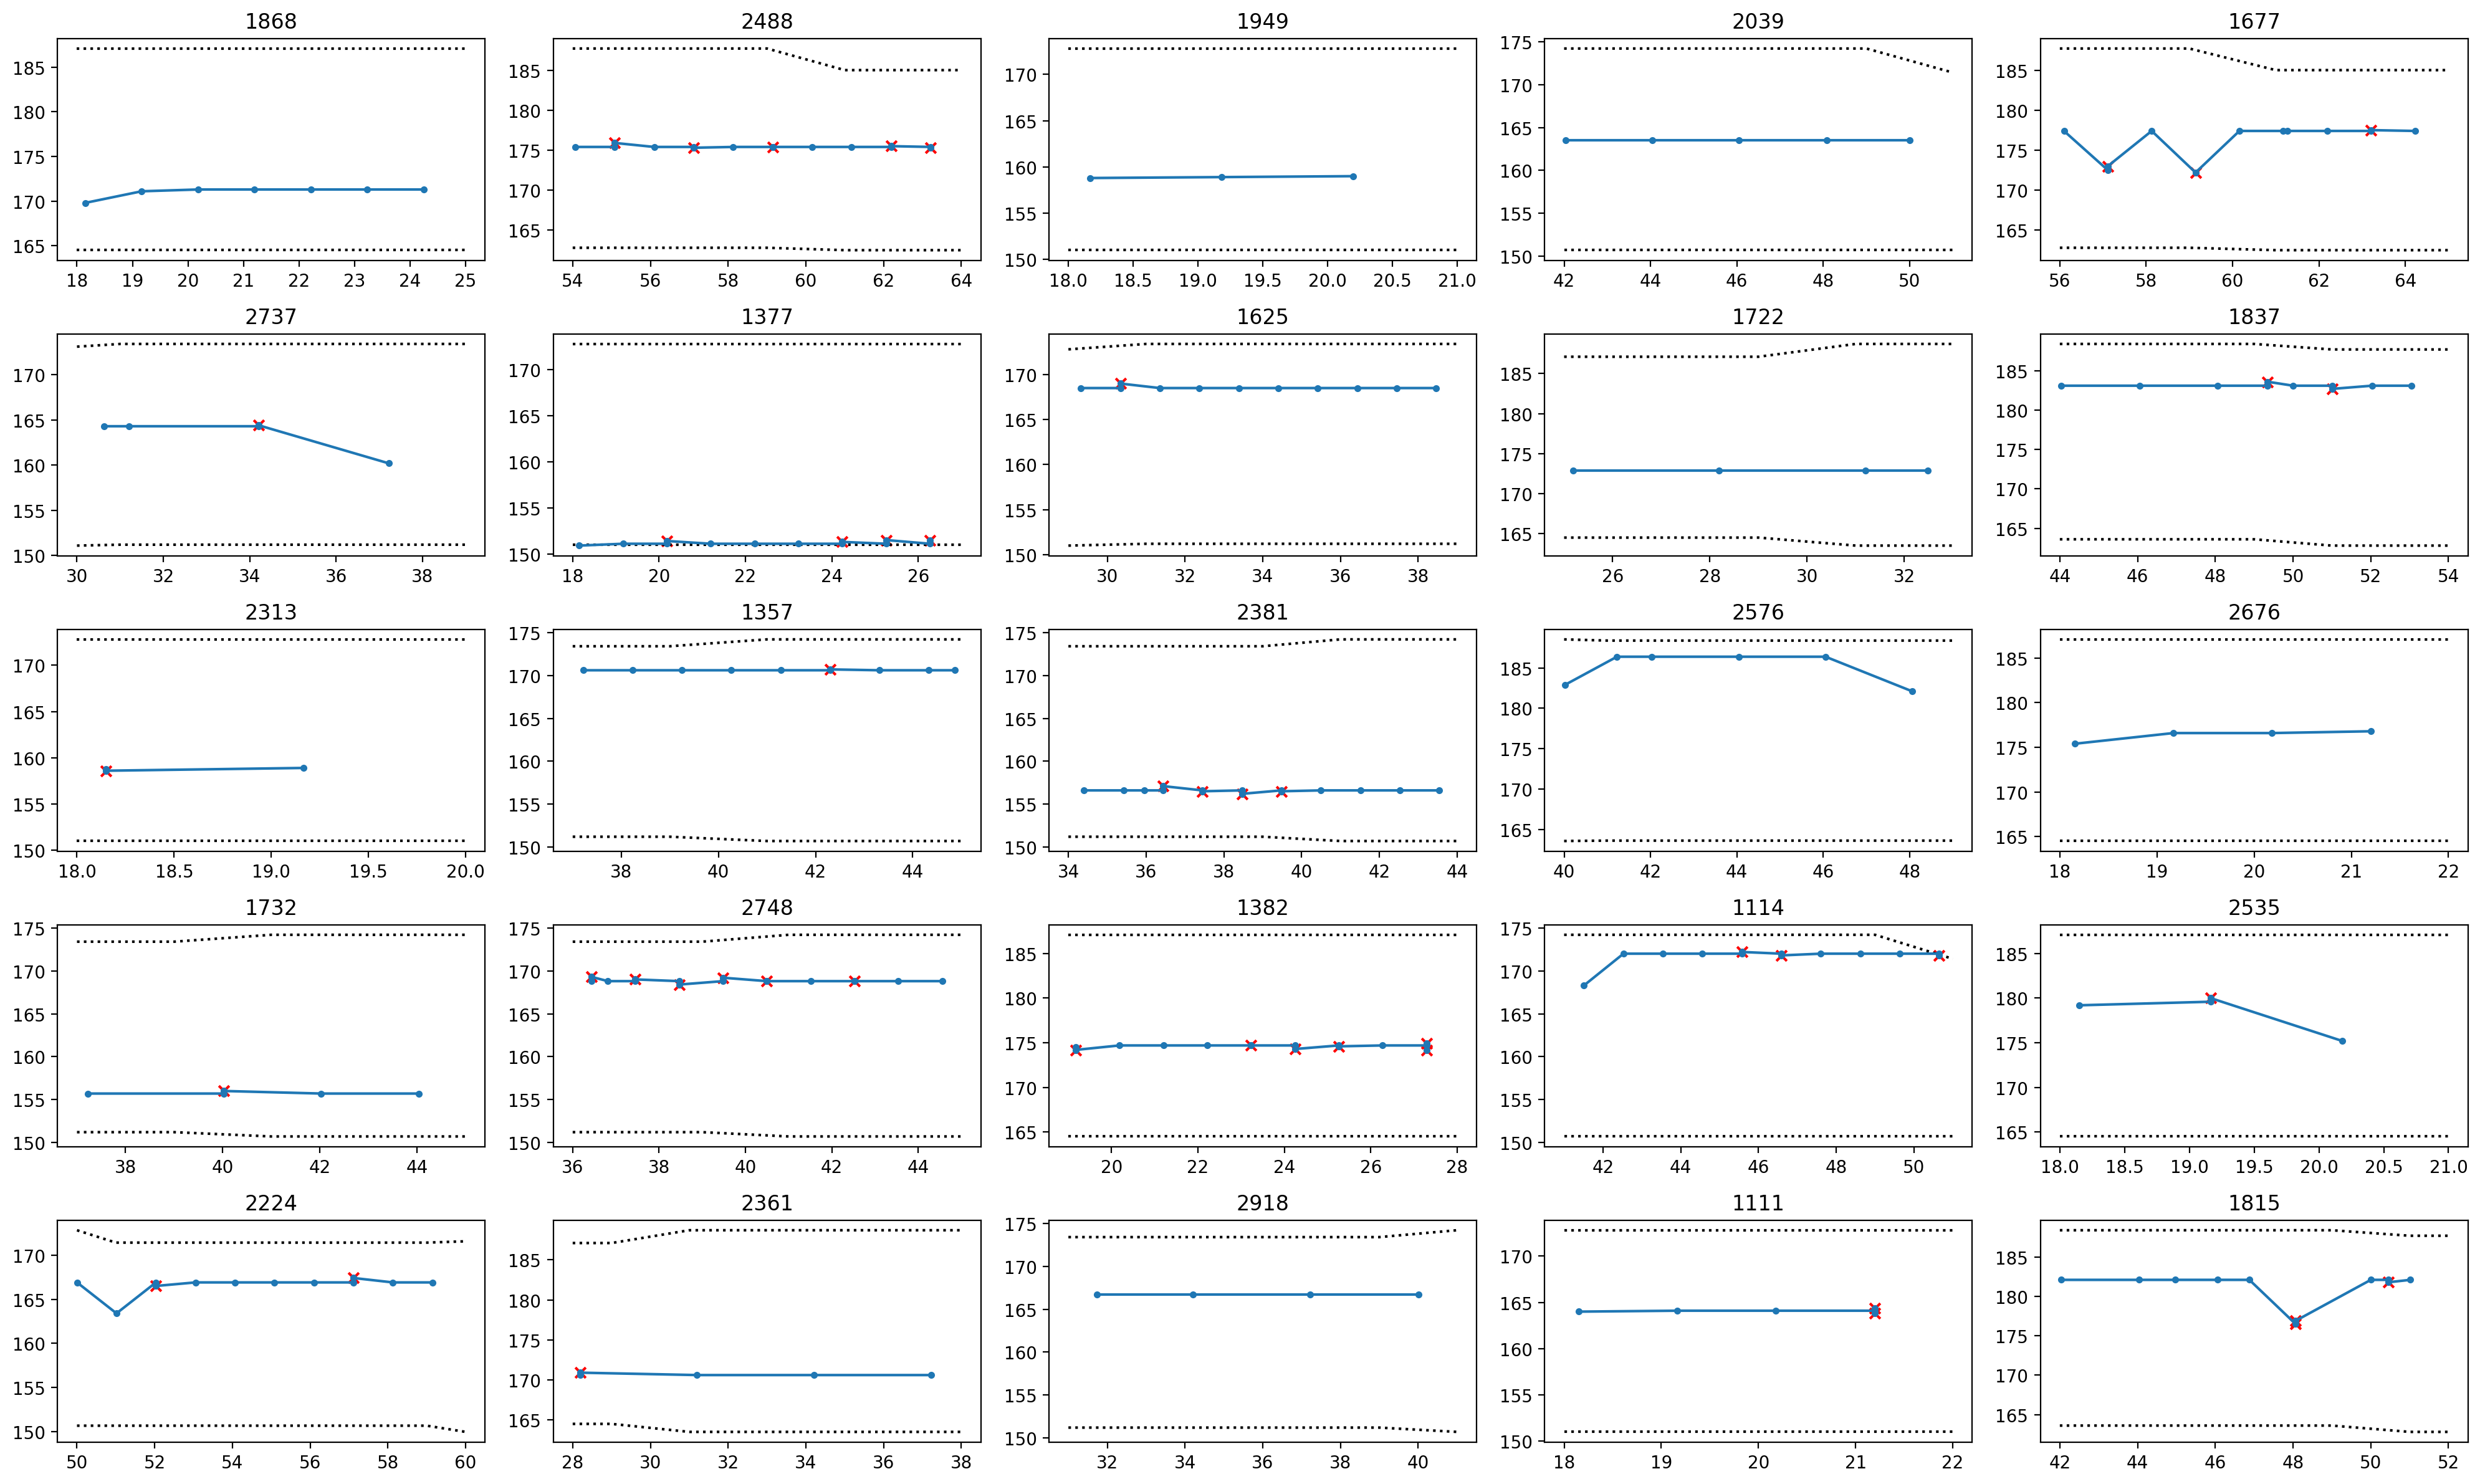

In [28]:
charts.five_by_five_view(obs_wbmi, sample, 'HEIGHTCM', wt_percentiles, ht_percentiles, bmi_percentiles, 'dotted')

# Building a Different Sample

This tool can be used to create samples that are tailored to specific interests. Views can easily be created on existing DataFrames and be used to generate different samples. Functionality available is described in the [Pandas DataFrame documentation](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html).

The cell below selects all observations with a weight exclusion of "Exclude-Moderate-EWMA". It then sorts by weight in descending order. The code then takes the top 50 values and selects 25 random, unique `subjids` from that set. Finally it plots the results. If there are fewer than 25 examples, but at least one, each example is shown. 

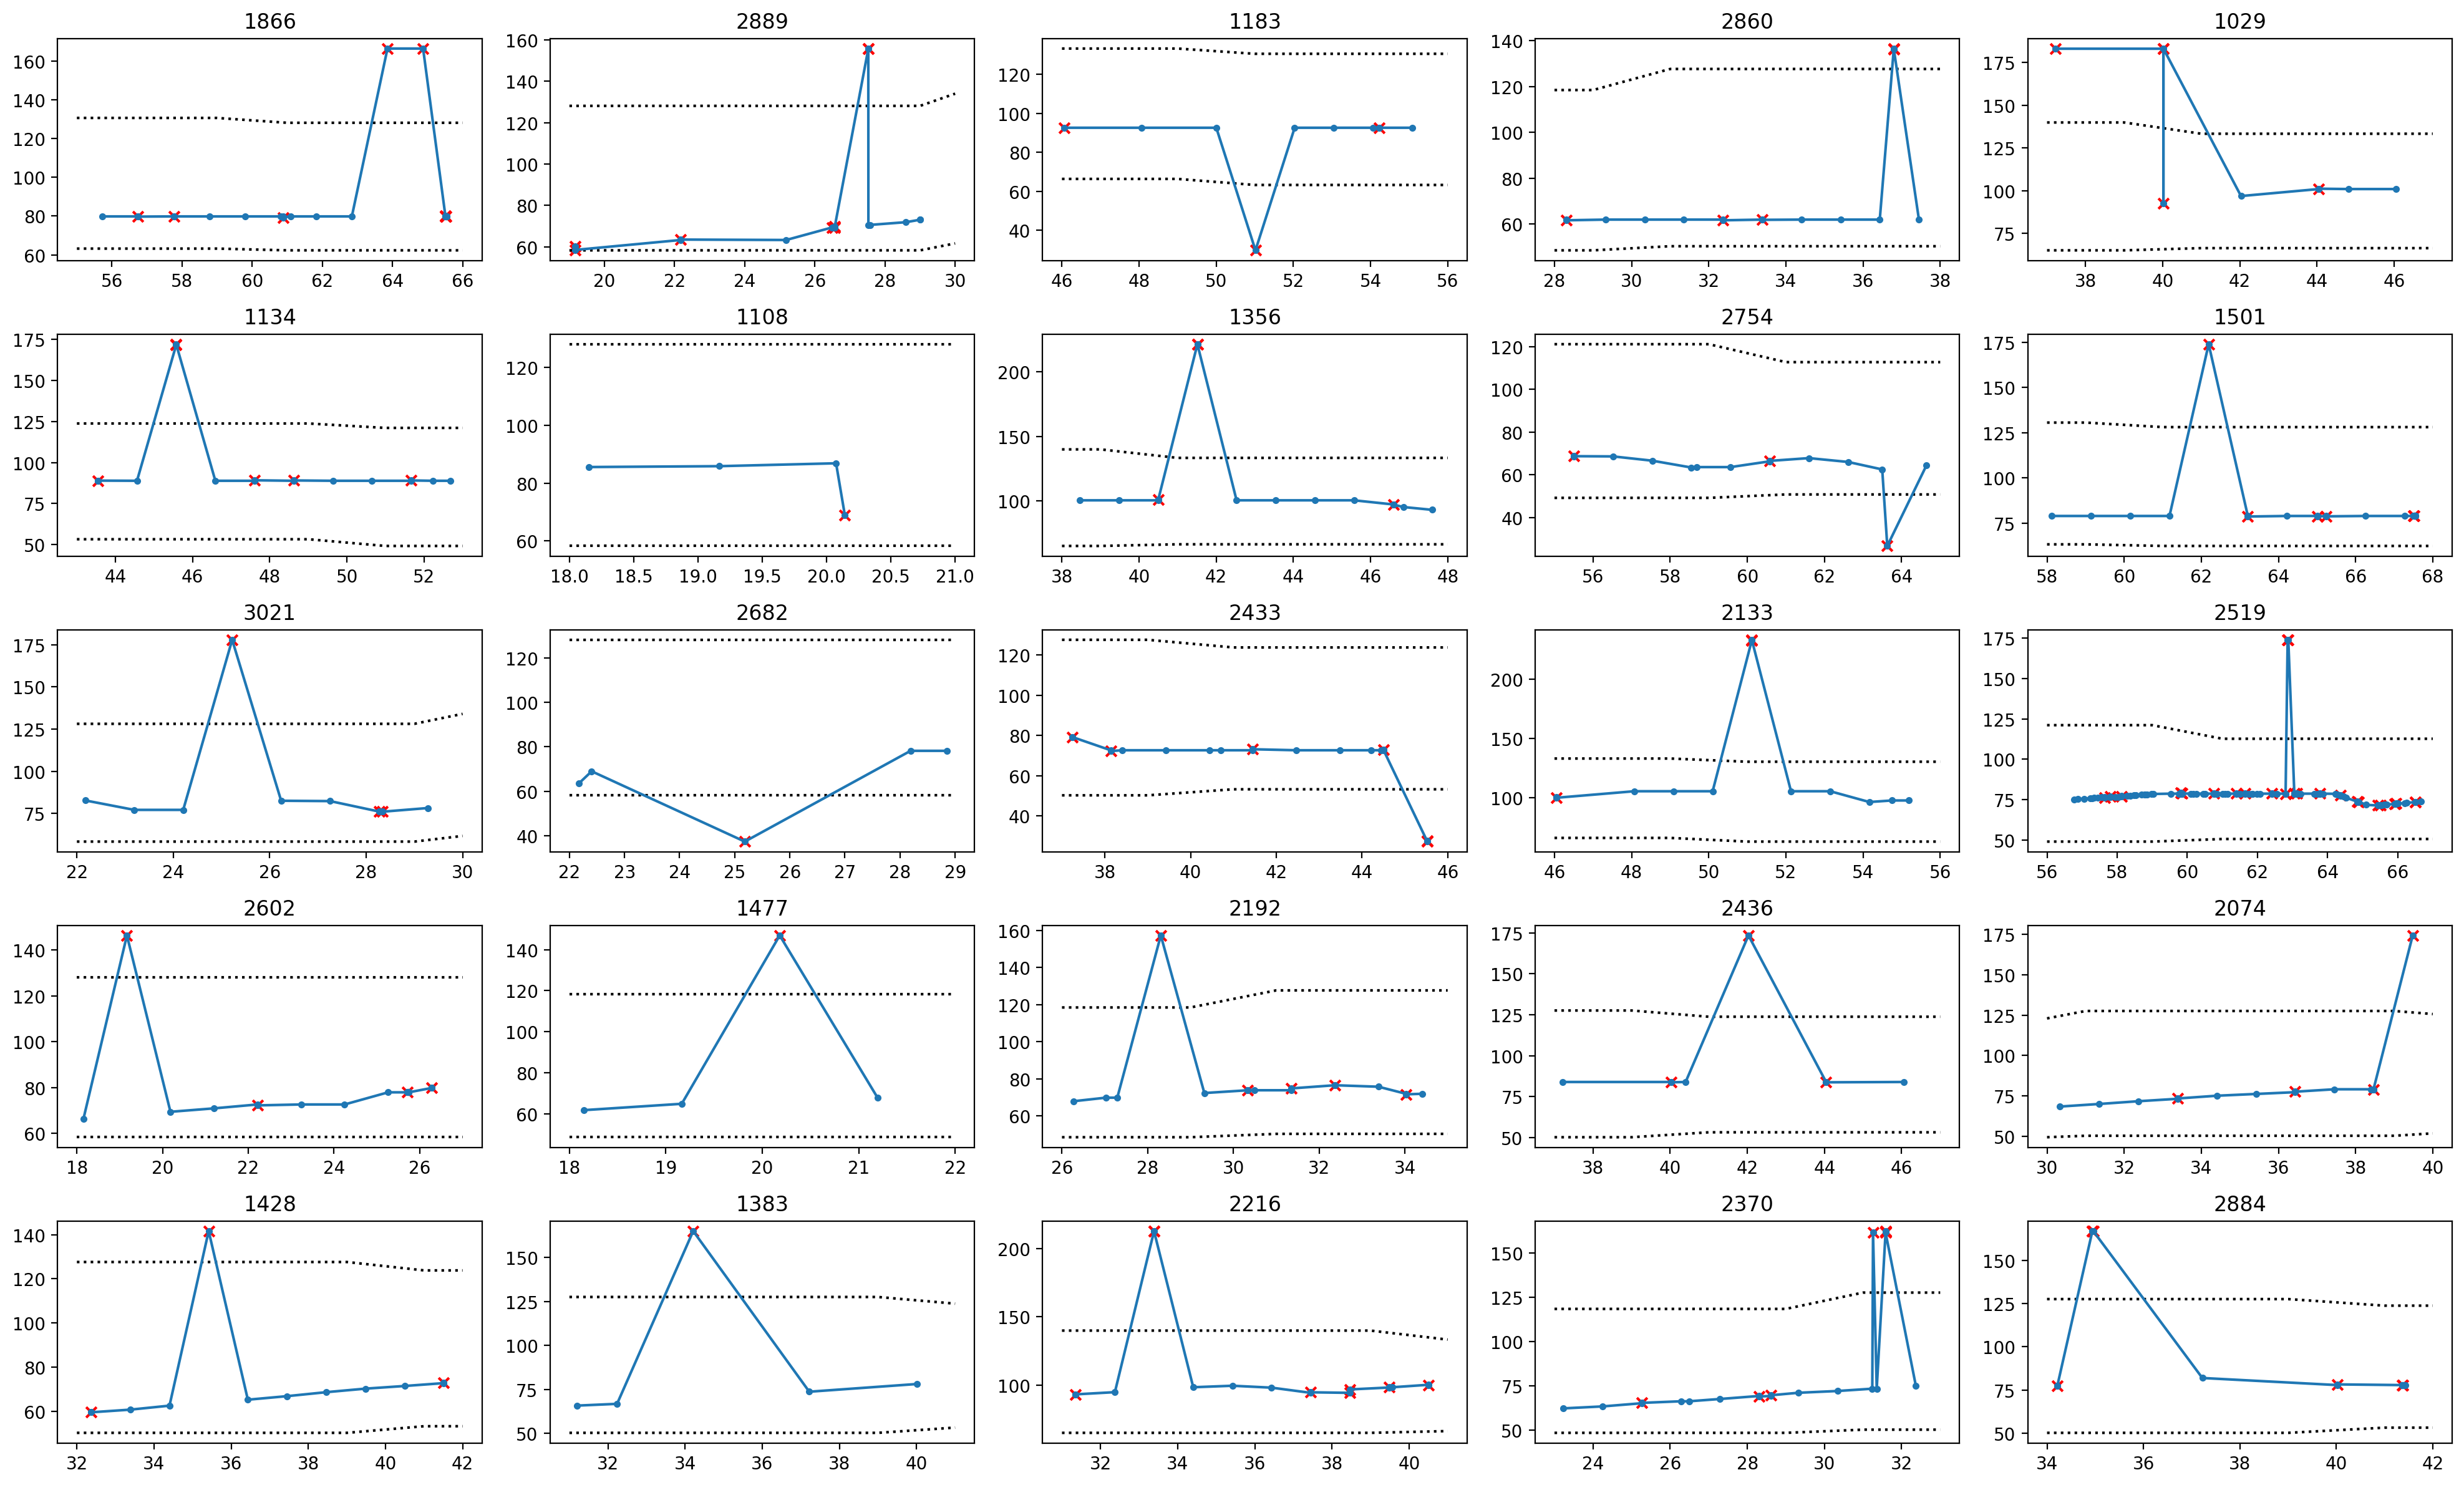

In [29]:
top_weight_moderate_ewma_ids = merged_df[merged_df.weight_cat == 'Exclude-Adult-EWMA-Moderate'].sort_values('weight', ascending=False).head(50)['subjid'].unique()
if len(top_weight_moderate_ewma_ids) >= 25:
    ewma_sample = np.random.choice(top_weight_moderate_ewma_ids, size=25, replace=False)
    charts.five_by_five_view(obs, ewma_sample, 'WEIGHTKG', wt_percentiles, ht_percentiles, bmi_percentiles, 'dotted')

## Visualizing the Top/Bottom 25 for a Given Category

The following cell uses the same function as above to create a 5 x 5 set of small multiple charts, but selects the top/bottom 25 individuals by growthcleanr category. The results can be sorted by maximum parameter, minimum parameter, starting age, or size of age range.

In [30]:
def edge25(obs, category, group, sort_order, param):
    filtered_by_cat = obs[(obs.clean_cat == category) & (obs.param == param)]
    # get list of relevant IDs
    filtered_sum = filtered_by_cat.groupby('subjid', as_index=False).agg(max_measure=('measurement', 'max'), min_measure=('measurement', 'min'), start_age=('age', 'min'), axis_range=('range', 'mean'))
    if group == 'largest':
        filtered_sum = filtered_sum.nlargest(25, 'max_measure')
    else:
        filtered_sum = filtered_sum.nsmallest(25, 'min_measure')
    filtered_sum.sort_values(by=[sort_order, 'subjid'], inplace=True)
    fig = charts.five_by_five_view(obs, filtered_sum.subjid.values, param, wt_percentiles, ht_percentiles, bmi_percentiles, 'dotted')
    plt.show()
    
interact(edge25, obs = fixed(obs_wbmi_mult), category = obs.clean_cat.unique(), 
         group = ['largest', 'smallest'], sort_order = ['max_measure', 'min_measure', 'start_age', 'axis_range'], param = ['WEIGHTKG', 'HEIGHTCM', 'BMI'])

interactive(children=(Dropdown(description='category', options=('Include', 'Exclude-Adult-Extraneous-Same-Day'…

<function __main__.edge25(obs, category, group, sort_order, param)>

# Visualizing Changes in Trajectory

The `charts.param_with_percentiles` function displays a chart showing BMI, height, or weight for an individual over time. Black bands representing the 5th and 95th percentiles for age and sex are shown with the individual's BMI, height, or weight shown in blue. The plot on the left represents all values. The plot on the right is only included values.

In [31]:
all_ids = obs_wbmi['subjid'].unique()
val = 2431 if 2431 in all_ids else np.random.choice(all_ids, size=1, replace=False)
interact(charts.param_with_percentiles, merged_df = fixed(obs_wbmi),
         subjid = widgets.Dropdown(options=all_ids, value=val,
                                         description='Subject ID:',disabled=False), 
         param = ['BMI', 'WEIGHTKG', 'HEIGHTCM'], wt_df = fixed(wt_percentiles), ht_df = fixed(ht_percentiles), bmi_df = fixed(bmi_percentiles))

interactive(children=(Dropdown(description='Subject ID:', index=1430, options=(1001, 1002, 1003, 1004, 1005, 1…

<function growthviz.charts.param_with_percentiles(merged_df, subjid, param, wt_df, ht_df, bmi_df)>

# Summary Statistics

The next cell generates summary statistics for the data set. The `sumstats.bmi_stats` function uses the `merged_df` DataFrame to compute values on the "clean" data, which means only included values as well as the "raw" values, which is all values for individuals.

| Column Name | Definition |
|--------|-------------|
| min_clean | Minimum Clean BMI Value |
| mean_clean | Average Clean BMI Value |
| max_clean | Maximum Clean BMI Value |
| sd_clean | Standard Deviation of Clean BMI Values |
| count_clean | Count of Patient Records with Clean BMI Values |
| min_raw | Minimum Raw BMI Value |
| mean_raw | Average Raw BMI Value |
| max_raw | Maximum Raw BMI Value |
| sd_raw | Standard Deviation of Raw BMI Values |
| count_raw | Count of All Patient Records |
| count_diff | Count of Patient Records with Excluded BMI Values |

The buttons can be used to add or remove columns from the table (all columns are shown by default - clicking a button will remove that column from the table).
The checkbox includes "missing" values (note: this will impact the raw columns as missing values may cause BMI values of infinity since they divide by 0 when missing). Missing values are not included by default.

In [32]:
min_toggle = widgets.ToggleButton(value=True, description='Minimum BMI', 
                                  tooltip="Click to hide or show the minimum BMI columns")
mean_toggle = widgets.ToggleButton(value=True, description='Mean BMI', 
                                   tooltip="Click to hide or show the mean BMI columns")
max_toggle = widgets.ToggleButton(value=True, description='Maximum BMI', 
                                  tooltip="Click to hide or show the maximum BMI columns")
std_toggle = widgets.ToggleButton(value=True, description='BMI Standard Deviation',
                                  tooltip="Click to hide or show the BMI standard deviation columns")
count_toggle = widgets.ToggleButton(value=True, description='Count',
                                    tooltip="Click to hide or show the count columns")
diff_toggle = widgets.ToggleButton(value=True, description='Count Difference',
                                   tooltip="Click to hide or show the count difference column")
age_range = widgets.IntRangeSlider(value=[20, 65], min=20, max=65, step=1, description='Age:', continuous_update=False,
                                   orientation='horizontal', readout=True, readout_format='d')
include_missing_values = widgets.Checkbox(value=False,description='Include Missing / Zero Heights and Weights',disabled=False,indent=False)
hbox = widgets.HBox([min_toggle, mean_toggle, max_toggle, std_toggle, count_toggle, diff_toggle])
ui = widgets.VBox([age_range, hbox, include_missing_values])
sum_out = widgets.Output()
widgets.interactive_output(sumstats.bmi_stats, {'merged_df': fixed(merged_df), 'include_min': min_toggle, 
         'include_mean': mean_toggle, 'include_max': max_toggle, 'include_std': std_toggle, 
         'include_mean_diff': diff_toggle, 'include_count': count_toggle,
         'out': fixed(sum_out), 'age_range': age_range, 'include_missing': include_missing_values})
display(ui, sum_out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<IPython.core.display.Markdown object>…

# Exporting Data

The following code allows you to export a DataFrame as a CSV file. When the cell below is run, the drop down will contain all DataFrames stored in variables in this notebook. Select the desired DataFrame and click Generate CSV. This will create the CSV file and provide a link to download it. DataFrames created in this notebook include:

| DataFrame | Description |
|--------|-------------|
| cleaned_obs | Original growthcleanr output read in from csv file |
| obs_full | Slightly modified version of `cleaned_obs` in format needed for use in notebook |
| obs | Patient observations within age range allowed for this notebook (18-80) |
| percentiles | Original CDC percentiles data |
| percentiles_clean | Expanded percentiles data with one row per year and standard deviation |
| bmi_percentiles | BMI portion of cleaned percentiles data for use in charts |
| wt_percentiles | Weight portion of cleaned percentiles data for use in charts |
| ht_percentiles | Height portion of cleaned percentiles data for use in charts |
| percentiles_wide | Percentiles data reshaped wide with one row per age and sex |
| merged_df | Data by subject and age that contains height, weight, and BMI on one row |
| obs_wbmi | Version of `obs` that has BMI values appended at end |
| mdf | Version of `merged_df` with added z-scores |
| obs_wbmi_mult | Version of `obs_wbmi` that only includes subjects with more than one recorded visit |

In [33]:
df_selector = widgets.Dropdown(options=processdata.data_frame_names(locals()), description='Data Frames')
generate_button = widgets.Button(description='Generate CSV')
ui = widgets.VBox([df_selector, generate_button])
csv_out = widgets.Output()

l = locals()
def on_button_clicked(b):
    processdata.export_to_csv(l, df_selector, csv_out)

generate_button.on_click(on_button_clicked)
    
display(ui, csv_out)

Output()

# Post Processing Data

This tool provides functions that allow the post processing of data. `processdata.clean_swapped_values` will look in a DataFrame for rows where the `height_cat` and `weight_cat` are both flagged for exclusions with "`Exclude-Adult-Swapped-Measurements`". It will then swap the `height` and `weight` values for those rows, and recalculate BMI. It will also create two new columns: `postprocess_height_cat` and `postprocess_weight_cat`. The values for these columns is copied from the original categories except in the case where swaps are fixed when it is set to "`Include-Fixed-Swap`".

The cell below copies the merged DataFrame and then cleans the swapped values.

In [34]:
cleaned = merged_df.copy()
cleaned = processdata.clean_swapped_values(cleaned)
cleaned[cleaned.weight_cat == 'Exclude-Adult-Swapped-Measurements'].head()

,id,subjid,age,sex,height_cat,include_height,category_x,colors_x,patterns_x,sort_order_x,...,category_y,colors_y,patterns_y,sort_order_y,weight,bmi,rounded_age,include_both,postprocess_height_cat,postprocess_weight_cat
1452,4197.0,1109,60.158795,1,Exclude-Adult-Swapped-Measurements,False,60-65,C0,,F,...,60-65,C0,,F,96.3,30.877696,60.0,False,Include-Fixed-Swap,Include-Fixed-Swap
4881,13788.0,1380,45.535934,1,Exclude-Adult-Swapped-Measurements,False,40-50,C0,,D,...,40-50,C0,,D,95.7,30.102963,46.0,False,Include-Fixed-Swap,Include-Fixed-Swap
6718,18487.0,1505,56.919918,1,Exclude-Adult-Swapped-Measurements,False,50-60,C0,,E,...,50-60,C0,,E,90.0,28.857660,57.0,False,Include-Fixed-Swap,Include-Fixed-Swap
6719,18489.0,1505,56.919918,1,Exclude-Adult-Distinct-3-Or-More,False,50-60,C0,,E,...,50-60,C0,,E,176.6,218.509999,57.0,False,Exclude-Adult-Distinct-3-Or-More,Exclude-Adult-Swapped-Measurements
6720,18490.0,1505,56.919918,1,Exclude-Adult-Extraneous-Same-Day,False,50-60,C0,,E,...,50-60,C0,,E,176.6,219.975686,57.0,False,Exclude-Adult-Extraneous-Same-Day,Exclude-Adult-Swapped-Measurements


# Developing New Visualizations

Users may take advantage of the predefined `sumstats.bmi_stats`, `charts.bmi_with_percentiles`, `charts.five_by_five_view`, `charts.overlap_view_adults` and `charts.top_ten` functions. For more information on these functions, execute the function name ending with a "?", which will bring up the inline help window. For example, `charts.five_by_five_view`

In [35]:
sumstats.bmi_stats?

In addition, users can take advantage of all of the plotting capabilities of [Matplotlib](https://matplotlib.org/stable/tutorials/index.html) and [Seaborn](https://seaborn.pydata.org/tutorial.html).